<a href="https://colab.research.google.com/github/apothula/dl/blob/main/Seg/04_UNet_Road_CE_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Semantic Segmentation using UNet (KITTI Road Dataset)</h1>

Another popular model for semantic segmentation introduced in 2015 is called UNet <a href="https://arxiv.org/pdf/1505.04597.pdf" target="_blank">U-Net: Convolutional Networks for Biomedical
Image Segmentation</a>. Unlike the FCN models introduced in previous notebooks, UNet does not use a specific backbone to perform feature extraction but rather develops an encoder / decoder framework organically with several skip connections between the two. In this notebook, we will develop an implementation of the UNet model and see how it performs on the KITTI Road dataset using a cross-entropy loss function. Note: the architecture diagram below is from the original research paper, which uses an input image size of 578 x 578. In our implementation, we will use an input image size of 224 x 224.

<img src='https://opencv.org/wp-content/uploads/2022/07/c4-05-unet-road-feature-image.png' align='center' width='1000'>

## Table of Contents

* [1 System Configuration](#1-System-Configuration)
* [2 Training and Dataset Configurations](#2-Training-and-Dataset-Configurations)
* [3 Modeling FCN32s with VGG-16 Backbone](#3-Modeling-FCN32s-with-VGG-16-Backbone)
* [4 Dataset Preparation](#4-Dataset-Preparation)
* [5 Custom Data Loader Class](#5-Custom-Data-Loader-Class)
* [6 Helper Functions and Utilities](#6-Helper-Functions-and-Utilities)
* [7 Using the Custom Data Loader Class](#7-Using-the-Custom-Data-Loader-Class)
* [8_Custom Accuracy Metric](#8-Custom-Accuracy-Metric)
* [9 Compile and Train the Model](#9-Compile-and-Train-the-Model)
* [10 Plot the Training Results](#10-Plot-the-Training-Results)
* [11 Perform Inference](#11-Perform-Inference)
* [12 Conclusion](#12-Conclusion)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob as glob
import albumentations as A
import requests
import zipfile

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Input,
                                     Conv2DTranspose, Activation,
                                     Dropout, concatenate)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

block_plot = False
plt.rcParams['image.cmap'] = 'gray'

## 1 System Configuration

In [ ]:
def system_config(SEED_VALUE):

    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config(7)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


## 2 Training and Dataset Configurations

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 2
    IMG_WIDTH:   int = 224
    IMG_HEIGHT:  int = 224
    DATA_TRAIN_IMAGES: str = 'dataset_kitti_road_segmentation/train/images/*.png'
    DATA_TRAIN_LABELS: str = 'dataset_kitti_road_segmentation/train/masks/*.png'
    DATA_VALID_IMAGES: str = 'dataset_kitti_road_segmentation/valid/images/*.png'
    DATA_VALID_LABELS: str = 'dataset_kitti_road_segmentation/valid/masks/*.png'

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 8
    EPOCHS:          int = 51
    LEARNING_RATE: float = 0.0001
    CHECKPOINT_DIR:  str = 'model_checkpoint/UNet_Road'

@dataclass(frozen=True)
class InferenceConfig:
    NUM_BATCHES:     int = 3

## 3  Implementing UNet
In the implementation below, we added dropout layers at each stage in the network, which helps mitigate the effects of overfitting, which is helpful since we are working with a pretty small dataset.

In [ ]:
def unet(num_classes, shape):

    model_input = Input(shape=shape)

    # Encoder_block-1.
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(model_input)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Encoder_block-2.
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Encoder_block-3.
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Encoder_block-4.
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Intermedicate_block.
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder_block-1.
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2),padding = 'same')(c5)
    # Lateral connection from Encoder_block-4.
    u6 = concatenate([u6,c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding= 'same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu',  padding= 'same')(c6)

    # Decoder_block-2.
    u7 = Conv2DTranspose(256, (2,2), strides = (2, 2), padding= 'same')(c6)
    # Lateral connection from Encoder_block-3.
    u7 = concatenate([u7,c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding= 'same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu',  padding= 'same')(c7)

    # Decoder_block-3.
    u8 = Conv2DTranspose(128, (2,2), strides= (2, 2),padding = 'same')(c7)
    # Lateral connection from Encoder_blcok-2.
    u8 = concatenate([u8,c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding= 'same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu',   padding= 'same')(c8)

    # Decoder_block-4.
    u9 = Conv2DTranspose(64, (2, 2), strides = (2, 2), padding= 'same')(c8)
    # Lateral connection from Encoder_blcok-1.
    u9 = concatenate([u9,c1], axis =3)
    c9 = Conv2D(64, (3, 3), activation ='relu',  padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation ='relu',  padding='same')(c9)

    # 1x1 convolution to limit the depth of the feature maps to the number of classes.
    outputs = Conv2D(num_classes, (1, 1), use_bias=False)(c9)

    model_output = Activation('softmax')(outputs)

    model = Model(inputs=model_input, outputs=model_output)

    return model

In [ ]:
model = unet(num_classes=DatasetConfig.NUM_CLASSES,
             shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 224, 224, 64  0           ['conv2d[0][0]']                 
                                )                                                             

## 4 Dataset Preparation

### 4.1 Download and Extract the Dataset

This notebook will use the road segmentation images from the <a href="http://www.cvlibs.net/datasets/kitti/eval_road.php" target="_blank"> KITTI Road Evaluation dataset</a>. Although you can find the original dataset from the above link, we are providing a smaller version of the dataset to work with. The dataset that we will download further below has the following structure.

```
dataset_kitti_road_segmentation/

    ├── train
    │   ├── images [247 samples]
    │   └── masks  [247 samples]
    └── valid
        ├── images [42 samples]
        └── masks  [42 samples]
```

In [ ]:
# To Download processed dataset.
def download_file(url, save_name):
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)

In [ ]:
# To Unzip the dataset file.
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [ ]:
save_name = "dataset_kitti_road_segmentation.zip"

if not os.path.exists(save_name):
    download_file(
        "https://www.dropbox.com/s/6vpsgn4gqtdiu01/dataset_kitti_road_segmentation.zip?dl=1",
        save_name
    )

    unzip(zip_file=save_name)

### 4.2 Mask Pre-Processing

There are a few important things to mention regarding the dataset:
* The segmentation mask has three colors (red, pink, and black). Red represents the background, pink represents the main road we wish to segment from the background, and black represents secondary roads/walkways other than the main road. We are only interested in the pink segmentation region as that consists of the main road in the original image.
* We, therefore, need to pre-process the segmentation masks in the dataset to create a binary mask consisting of just the main road and the background.
* The following sequence summarizes the processing steps that we will implement further below in the notebook. The main thing to note is that we create a single channel mask whoes pixel values represent the class IDs.
* When we display the segmentation results we can use a color map (dictionary) to map class IDs to colors. Since the original color map is harder to visualize we decided to use a different color assignment for the two classes for visualization purposes (green for the main road and black for the background).

<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-mask-preprocessing.png" align='center' width=700>

## 5 Custom Data Loader Class

The next code block defines the `CustomSegDataLoader` class that we developed in the introductory notebook in this module. The only differnece is that this version uses a simplified verion of the `transforms()` method which only includes horizontal flipping.

In [ ]:
# Custom Class for creating training and validation (segmentation) dataset objects.
class CustomSegDataLoader(Sequence):

    def __init__(self, batch_size, image_size, image_paths, mask_paths, num_classes, aug):

        self.batch_size  = batch_size
        self.image_size  = image_size
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.num_classes = num_classes
        self.aug = aug

        self.x = np.empty((self.batch_size,) + self.image_size + (3,), dtype="float32")
        self.y = np.empty((self.batch_size,) + self.image_size, dtype="float32")

        if self.aug:
            self.train_transforms = self.transforms()

        self.resize_transforms = self.resize()

    def __len__(self):

        return len(self.mask_paths) // self.batch_size

    def transforms(self):

        # Data augmentation.
        train_transforms = A.Compose([A.HorizontalFlip(p=0.33),])
        return train_transforms

    def resize(self):

        resize_transforms = A.Resize(
            height=self.image_size[0], width=self.image_size[1],
            interpolation=cv2.INTER_NEAREST,
            always_apply=True, p=1
        )
        return resize_transforms

    def reset_array(self):
        self.x.fill(0.)
        self.y.fill(0.)

    def __getitem__(self, idx):
        self.reset_array()
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i : i + self.batch_size]
        batch_mask_paths = self.mask_paths[i : i + self.batch_size]

        for j, (input_image, input_mask) in enumerate(zip(batch_image_paths, batch_mask_paths)):

            # Read the image and convert to RGB.
            img = cv2.imread(input_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Read the mask and convert to RGB.
            msk = cv2.imread(input_mask)
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)

            # Resize the image and mask.
            resized  = self.resize_transforms(image=img, mask=msk)
            img, msk = resized['image'], resized['mask']

            if self.aug:
                # Apply augmentations.
                train_augment = self.train_transforms(image=img, mask=msk)
                img, msk = train_augment['image'], train_augment['mask']

            # Store image in x.
            self.x[j] = img / 255. # Normalizing image to be in range [0.0, 1.0]

            # Convert RGB segmentation mask to multi-channel (one-hot) encoded arrays where
            # each channel represents a single class whose pixel values are either 0 or 1,
            # where a 1 represents a pixel location associated with the class that corresponds
            # to the channel.
            msk = rgb_to_onehot(msk)

            # Convert the multi-channel (one-hot encoded) mask to a single channel (grayscale)
            # representation whose values contain the class IDs for each class (essentially
            # collapsing the one-hot encoded arrays into a single channel).
            self.y[j] = msk.argmax(-1)

        return self.x, self.y

## 6 Helper Functions and Utilities

The dictionary below defines the mapping between the final two class IDs and the colors we will use to represent them in the final segmentation map. These colors are arbitrary. Since we pre-processed the original ground truth masks, we are free to choose any colors for the final segmentation maps.

In [ ]:
id2color = {
    0: (255, 0, 0),   # Background: red
    1: (255, 0, 255), # Road: pink
}

id2color_display = {
    0: (0, 0, 0),     # Background: black
    1: (0, 255, 0),   # Road: green
}

When preparing the masks in the custom data loader class, we need to convert the RGB images to one-hot encoded images where the number of channels will be the same as the number of channels (classes) in the dataset. The following function performs this conversion.

In [ ]:
# Function to one-hot encode RGB mask labels.
def rgb_to_onehot(rgb_arr, color_map=id2color, num_classes=DatasetConfig.NUM_CLASSES):

    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros( shape, dtype=np.float32 )

    for i, classes in enumerate(color_map):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_map[i], axis=1).reshape(shape[:2])

    return arr

We will also need to make use of the function below that will convert a single-channel mask to an RGB representation for visualization purposes. Each class ID in the single-channel mask will be converted to a different color according to the `id2color` dictionary mapping.

In [ ]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):

    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))

    for k in color_map.keys():
        output[single_layer==k] = color_map[k]

    return np.float32(output) / 255. # return a floating point array in range [0.0, 1.0]

Helper function to overlay an RGB segmentation map on top of an RGB image.

In [ ]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return np.clip(image, 0.0, 1.0)

The convenience function below will display the original image, the ground truth mask, and the ground truth mask overlayed on the original image. Note that there is an optional argument that allows you to control if the ground truth mask is displayed as a grayscale image or a color image.

In [ ]:
def display_image_and_mask(data_list, color_mask=False, color_map=id2color):

    plt.figure(figsize=(16, 6))
    title = ['GT Image', 'GT Mask', 'Overlayed Mask']

    grayscale_gt_mask = data_list[1]

    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)

    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], rgb_gt_mask)

    data_list.append(overlayed_image)

    for i in range(len(data_list)):
        plt.subplot(1, len(data_list), i+1)
        plt.title(title[i])
        if title[i] == 'GT Mask':
            if color_mask:
                plt.imshow(np.array(rgb_gt_mask))
            else:
                plt.imshow(np.array(grayscale_gt_mask))
        else:
            plt.imshow(np.array(data_list[i]))
        plt.axis('off')

    plt.show()

## 7 Using the Custom Data Loader Class

Here we define the `create_datasets()` function that will be used below to generate training and validation dataset objects for the KITTI Road dataset. Notice that the augmentation flag for the validation dataset is explicitly set to `False` since data augmentation should only be an option for the training dataset.

In [ ]:
def create_datasets(aug=False):

    # Training image and mask paths.
    train_images = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_IMAGES}"))
    train_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_LABELS}"))

    # Validation image and mask paths.
    valid_images = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_IMAGES}"))
    valid_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_LABELS}"))

    # Train data loader.
    train_ds = CustomSegDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=train_images,
                                   mask_paths=train_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=aug,
                                  )
    # Validation data loader.
    valid_ds = CustomSegDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=valid_images,
                                   mask_paths=valid_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=False,
                                  )

    return train_ds, valid_ds

Now we call the above function to create the dataset objects and notice that the augmentation flag is set to `True`, but is only applied to the training dataset in the function above.

In [ ]:
train_ds, valid_ds = create_datasets(aug=True)

### 7.1 Display Sample Training Images

In the code cell below, we loop over the first three images in the training dataset and display the original image, the associated ground truth mask, and the ground truth mask overlayed on the original image. The overlay helps us better visualize the segmented classes in the context of the original image.

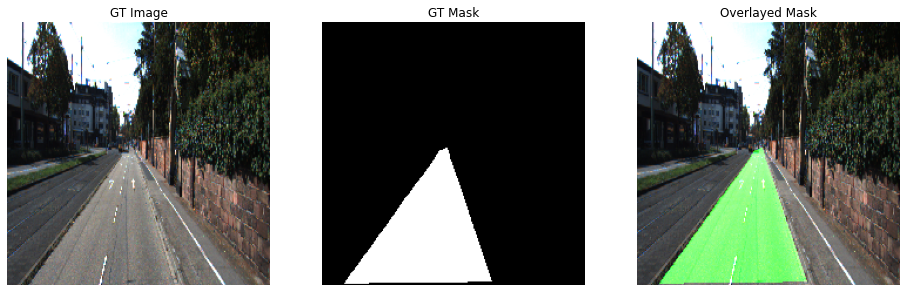

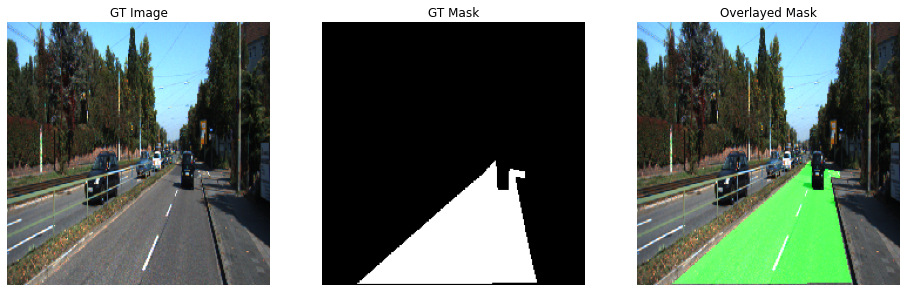

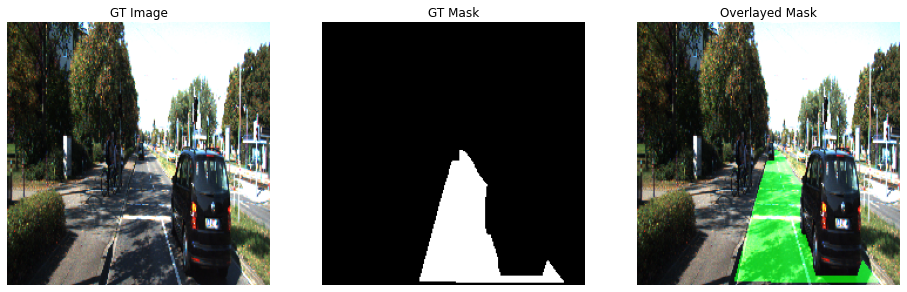

In [ ]:
for i, (images, masks) in enumerate(train_ds):
    if i == 3:
        break
    image, mask = images[0], masks[0]
    display_image_and_mask([image, mask], color_mask=False, color_map=id2color_display)

## 8 Custom Accuracy Metric

In this section, we define two custom accuracy metric functions. We will show how these metrics can be added to the training processing pipeline in the next section below. In future notebooks, we will develop custom loss functions based on the code in these functions.

### 8.1 Mean IoU Metric

In [ ]:
def mean_iou(y_true, y_pred):
    """
    Arguments:
    y_true (ndarray or tensor): Ground truth mask (G). Shape: (batch_size, height, width)
                               Sparse representation of segmentation mask.

    y_pred (ndarray or tensor): Prediction (P) from the model with or without softmax.
                                Shape: (batch_size, height, width, num_classes).

    return (scalar): Classwise mean IoU Metric.
    """

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    # Convert single channel (sparse) ground truth labels to one-hot encoding for metric computation.
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)

    # Convert multi-channel predicted output to one-hot encoded thresholded output for metric computation.
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Axes corresponding to image width and height: [B, H, W, C].
    axes = (1, 2)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=axes)

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=axes) + tf.math.reduce_sum(y_pred, axis=axes)

    # Union: Shape: (batch_size, num_classes)
    union = total - intersection

    # Boolean (then converted to float) value for each class if it is present or not.
    # Shape: (batch_size, num_classes)
    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)

    # Sum along axis(1) to get number of classes in each image.
    # Shape: (batch_size,)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    # Here, we use tf.math.divide_no_nan() to prevent division by 0 (i.e., 0/0 = 0).
    # Shape: (batch_size, num_classes)
    iou = tf.math.divide_no_nan(intersection, union)

    # IoU per image. Average over the total number of classes present in y_true and y_pred.
    # Shape: (batch_size,)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present

    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)

    return mean_iou

## 9 Compile and Train the Model

### 9.1 Adding Custom Metrics

To add custom metrics we can simply specify the function names in the list of `metrics` as shown in the code cell below when we compile the model.

`metrics=['accuracy', mean_iou]`

In [ ]:
model.compile(optimizer=Adam(learning_rate=TrainingConfig.LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', mean_iou],
             )

### 9.2 Adding Model Checkpoint Callback

In the next code cell, we accomplish two important things. First, we create a new directory for the current training model checkpoint to be saved. This will ensure that the previous training checkpoints are not overwritten. We also create a `ModelCheckpoint` callback to save the best model according to the smallest validation loss. This will ensure that we don't need to manually monitor the training for the "best" model.

In [ ]:
# Create a new checkpoint directory every time.
if not os.path.exists(TrainingConfig.CHECKPOINT_DIR):
    os.makedirs(TrainingConfig.CHECKPOINT_DIR)

num_versions = len(os.listdir(TrainingConfig.CHECKPOINT_DIR)) + 1
version_dir = TrainingConfig.CHECKPOINT_DIR +'/version_roadseg_' + str(num_versions)
os.makedirs(version_dir)

# Callback to save the best model based on validation loss.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=version_dir,
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='auto',
                                                               save_best_only=True,
                                                              )

### 9.3 Train the Model

In [ ]:
history = model.fit(train_ds,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_data=valid_ds,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=[model_checkpoint_callback],
                   )

Epoch 1/51
30/30 [==============================] - 29s 453ms/step - loss: 1.6473 - accuracy: 0.7341 - mean_iou: 0.4140 - val_loss: 0.7414 - val_accuracy: 0.6752 - val_mean_iou: 0.4650
Epoch 2/51
30/30 [==============================] - 14s 449ms/step - loss: 0.5828 - accuracy: 0.8026 - mean_iou: 0.4876 - val_loss: 0.4466 - val_accuracy: 0.8032 - val_mean_iou: 0.5770
Epoch 3/51
30/30 [==============================] - 15s 482ms/step - loss: 0.4019 - accuracy: 0.8228 - mean_iou: 0.5055 - val_loss: 0.3270 - val_accuracy: 0.8522 - val_mean_iou: 0.5913
Epoch 4/51
30/30 [==============================] - 8s 250ms/step - loss: 0.3113 - accuracy: 0.8549 - mean_iou: 0.5757 - val_loss: 0.3714 - val_accuracy: 0.8085 - val_mean_iou: 0.6276
Epoch 5/51
30/30 [==============================] - 15s 468ms/step - loss: 0.2505 - accuracy: 0.8887 - mean_iou: 0.6977 - val_loss: 0.2337 - val_accuracy: 0.9021 - val_mean_iou: 0.7590
Epoch 6/51
30/30 [==============================] - 8s 251ms/step - loss: 0.

## 10 Plot the Training Results

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

Now that these accuracy metrics have been added to the `metrics` list, we can access them in the training history object and plot them as shown below.

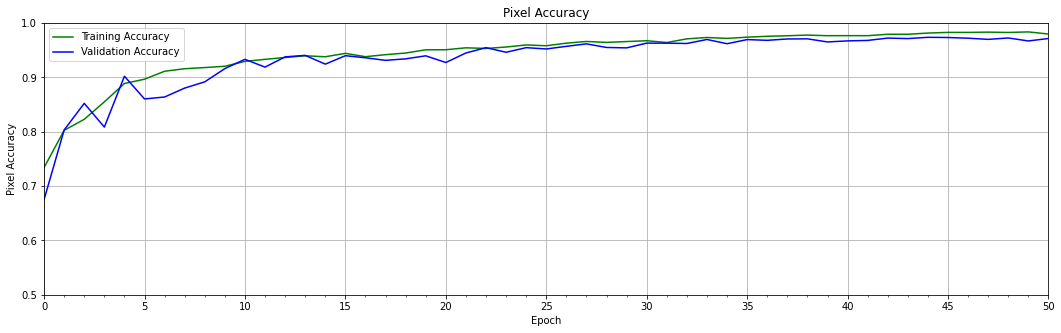

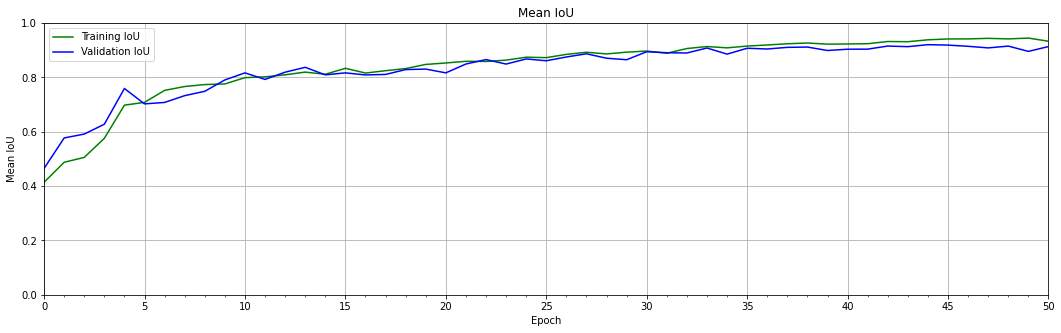

In [ ]:
# Pixel accuracy.
train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

# Mean IoU.
train_iou = history.history["mean_iou"]
valid_iou = history.history["val_mean_iou"]

plot_results([ train_acc, valid_acc ],
            ylabel="Pixel Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_iou, valid_iou ],
            ylabel="Mean IoU",
            ylim = [0.0, 1.0],
            metric_name=["Training IoU", "Validation IoU"],
            color=["g", "b"])

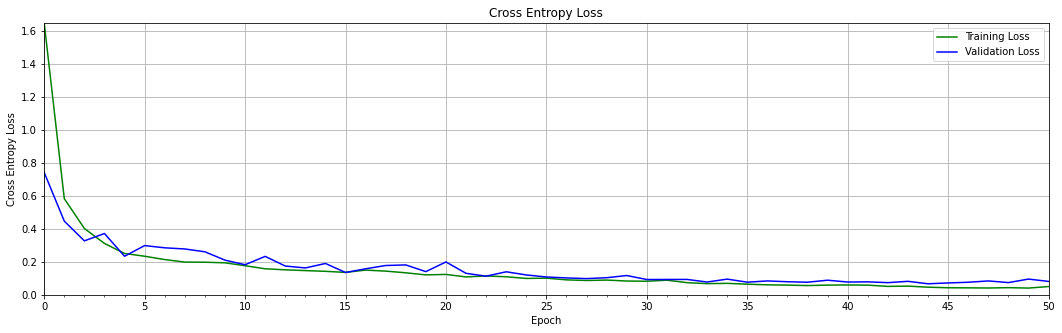

In [ ]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

max_loss = max(max(train_loss), max(valid_loss))

plot_results([ train_loss, valid_loss ],
            ylabel="Cross Entropy Loss",
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

## 11 Perform Inference

For inference, we will use the same validation data as we did during training. We will plot the ground truth images, the ground truth masks, and the predicted mask overlayed on the ground truth images.

### 11.1 Load the Trained Model

When loading the model, we need to specify the optional `custom_objects` dictionary mapping names (strings) to custom classes or functions to be considered during deserialization.

In [ ]:
trained_model = tf.keras.models.load_model(version_dir,
                                           custom_objects={'mean_iou':mean_iou})

In [ ]:
evaluate = trained_model.evaluate(valid_ds)

print(f"Model evaluation accuracy: {evaluate[1]*100.:.3f}")
print(f"Model evaluation mean IoU: {evaluate[2]*100.:.3f}")

5/5 [==============================] - 1s 192ms/step - loss: 0.0668 - accuracy: 0.9737 - mean_iou: 0.9202
Model evaluation accuracy: 97.367
Model evaluation mean IoU: 92.023


### 11.2 Inference

In [ ]:
def inference(model, dataset):

    num_batches_to_process = InferenceConfig.NUM_BATCHES

    for idx, data in enumerate(dataset):

        batch_img, batch_mask = data[0], data[1]
        pred_all = (model.predict(batch_img)).astype('float32')
        pred_all = pred_all.argmax(-1)
        batch_img = (batch_img).astype('uint8')
        if idx == num_batches_to_process:
            break

        for i in range(0, len(batch_img)):

            fig = plt.figure(figsize=(20,8))

            # Display the original image.
            ax1 = fig.add_subplot(1,4,1)
            ax1.imshow(batch_img[i])
            ax1.title.set_text('Actual frame')
            plt.axis('off')

            # Display the ground truth mask.
            true_mask = batch_mask[i]
            ax2 = fig.add_subplot(1,4,2)
            ax2.set_title('Ground truth labels')
            ax2.imshow(true_mask)
            plt.axis('off')

            # Display the predicted segmentation mask.
            pred_mask = pred_all[i]
            ax3 = fig.add_subplot(1,4,3)
            ax3.set_title('Predicted labels')
            ax3.imshow(pred_mask)
            plt.axis('off')

            # Display the predicted segmentation mask overlayed on the original image.
            pred_mask_rgb = num_to_rgb(pred_all[i], color_map=id2color_display)
            overlayed_image = image_overlay((batch_img[i]), np.array(pred_mask_rgb.astype('uint8')))
            ax4 = fig.add_subplot(1,4,4)
            ax4.set_title('Overlayed image')
            ax4.imshow(overlayed_image)
            plt.axis('off')

            plt.show()

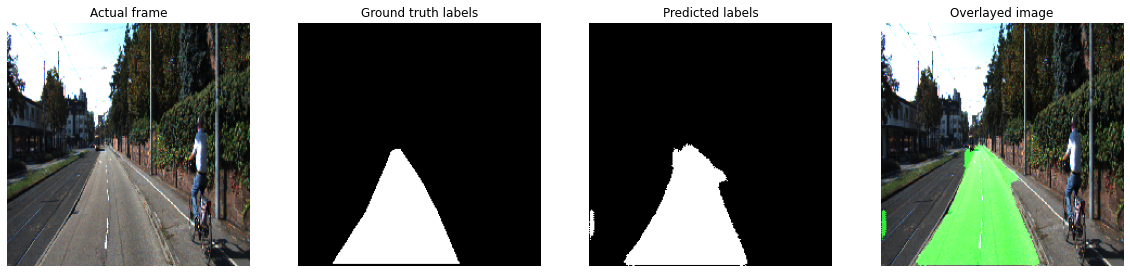

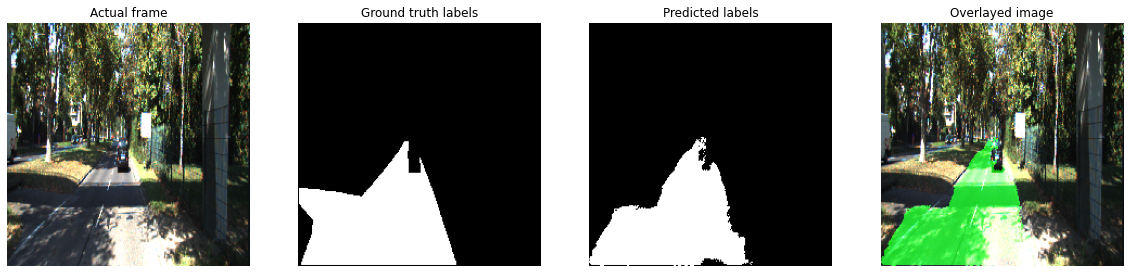

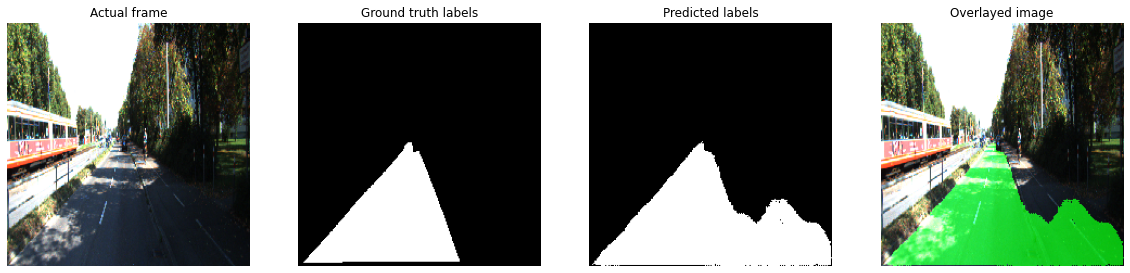

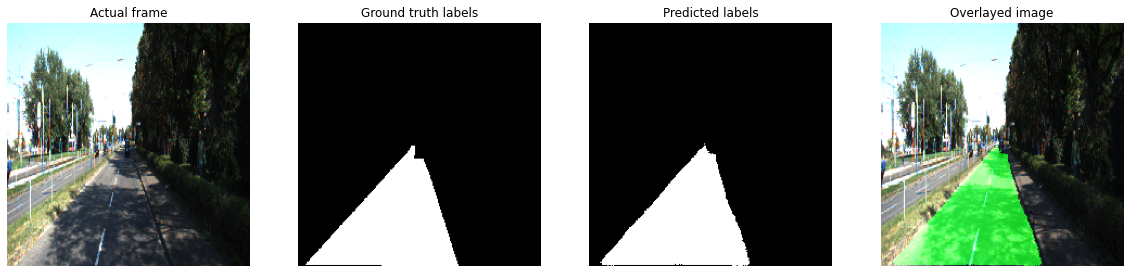

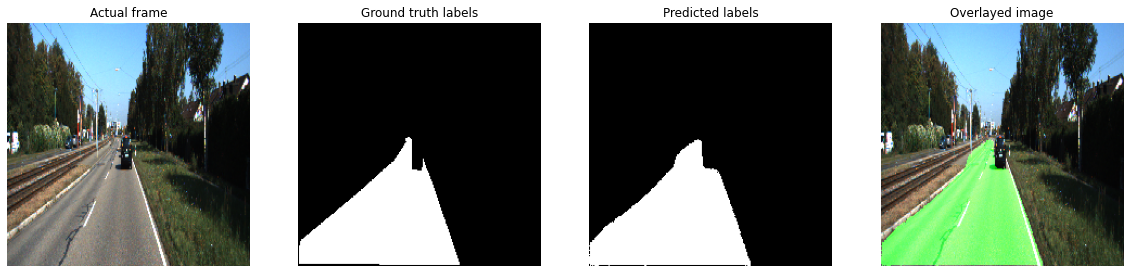

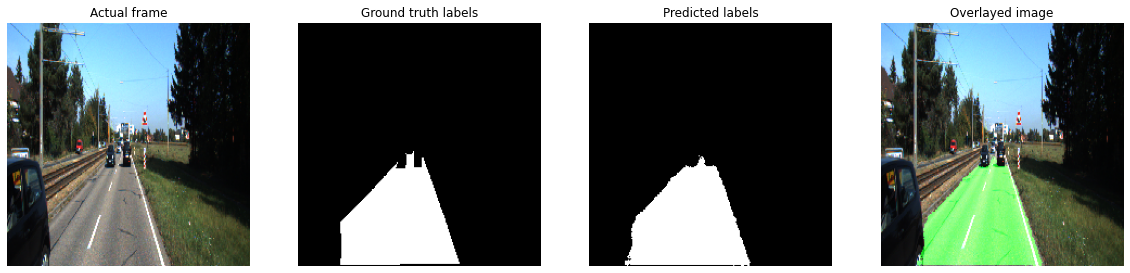

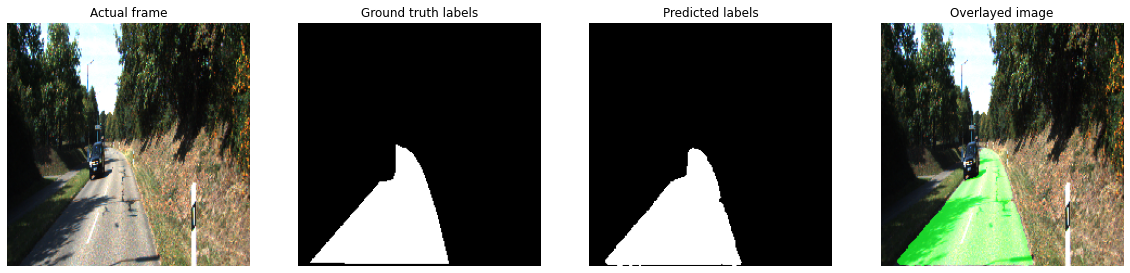

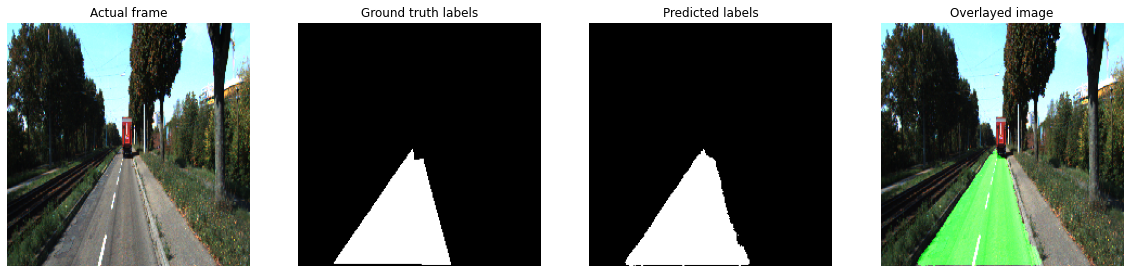

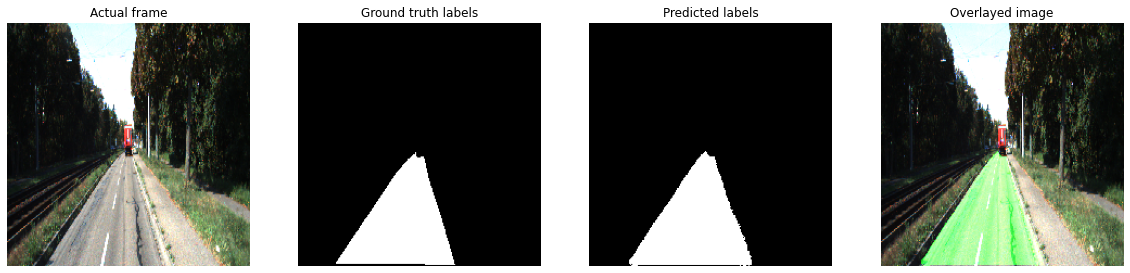

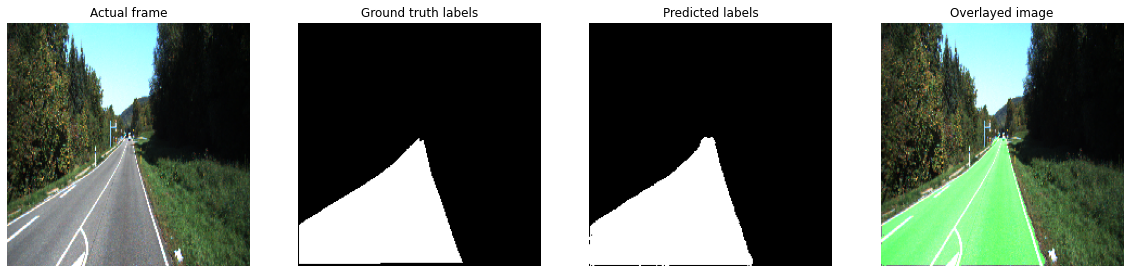

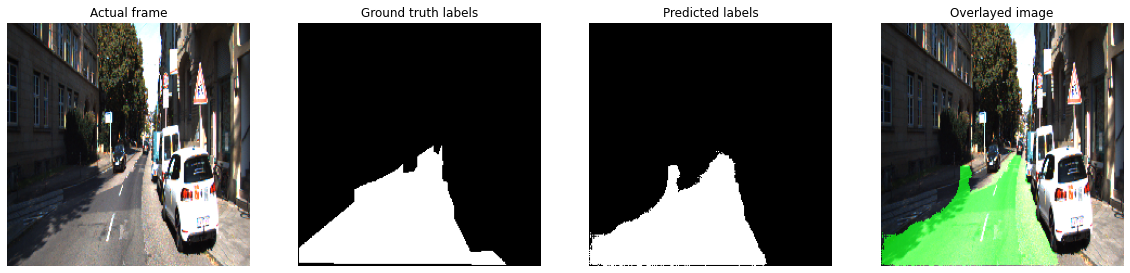

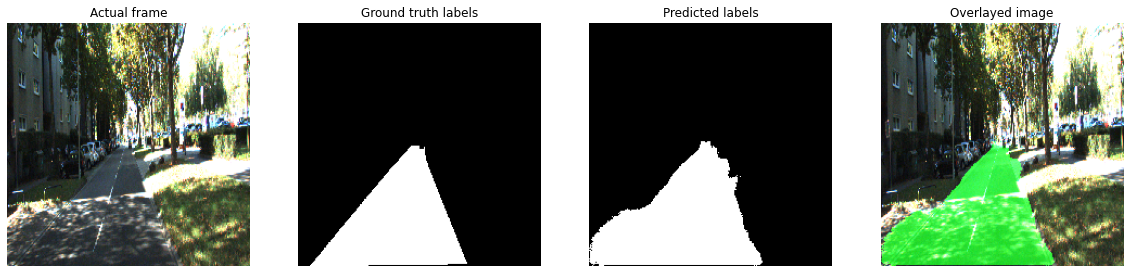

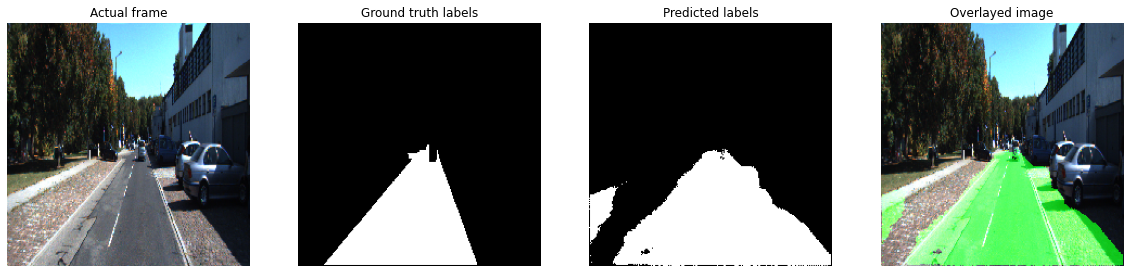

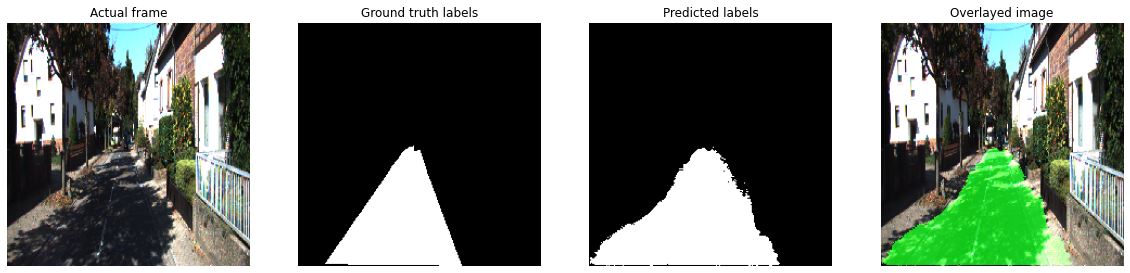

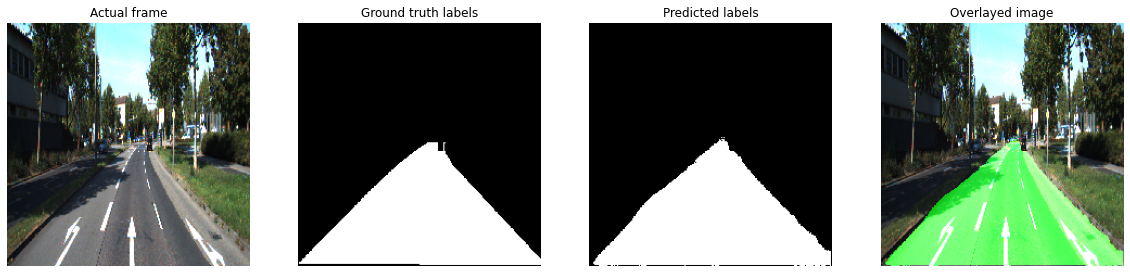

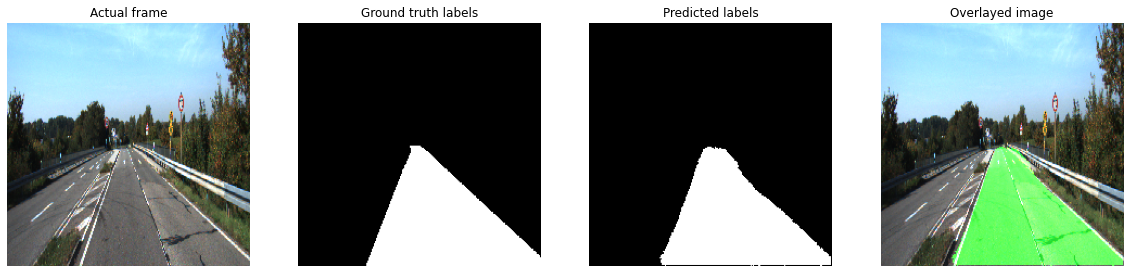

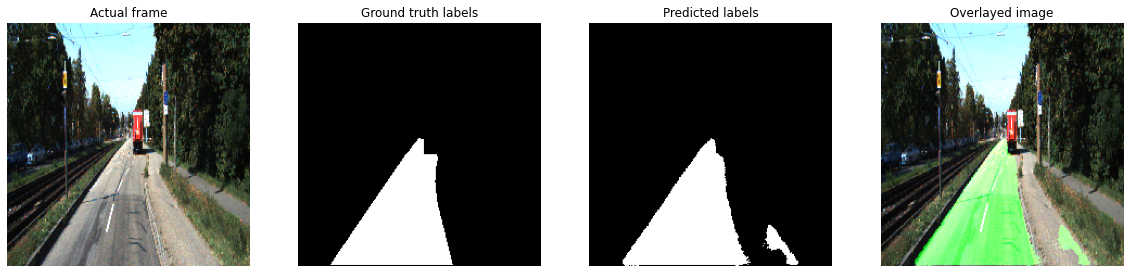

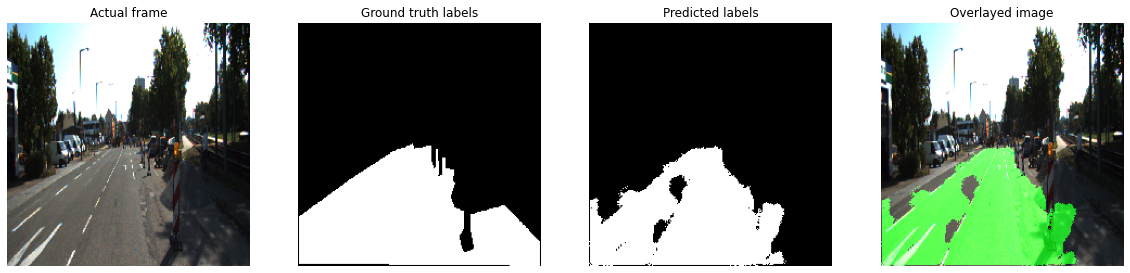

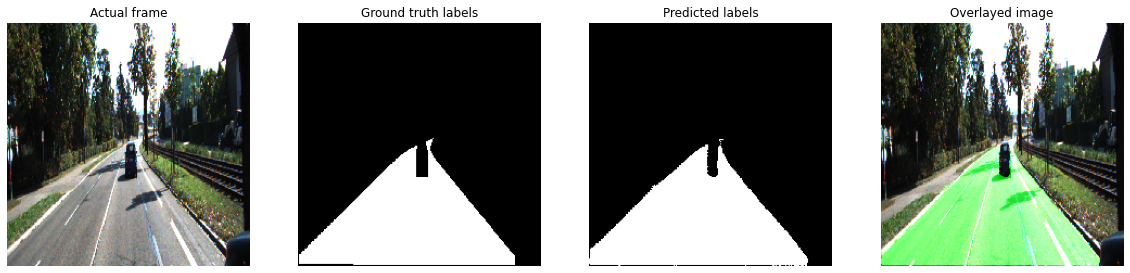

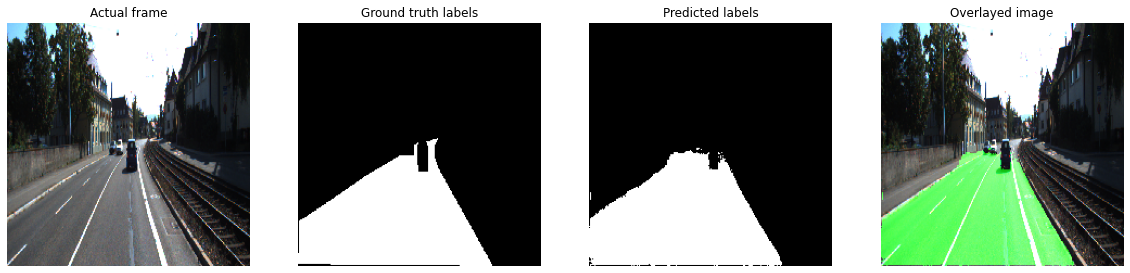

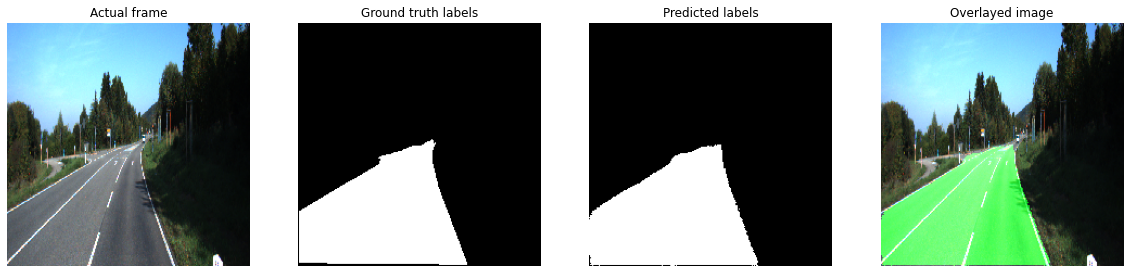

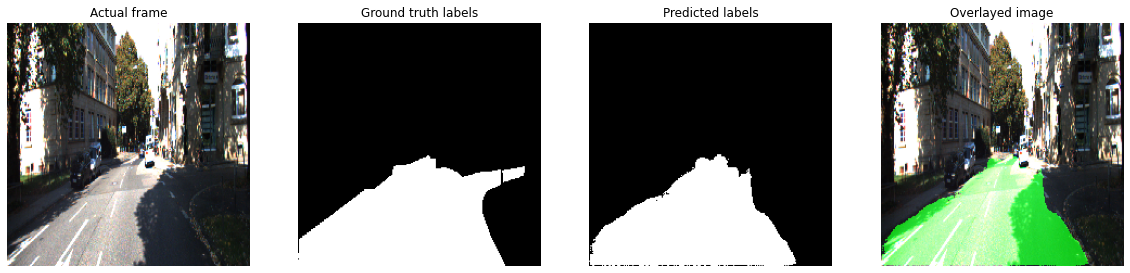

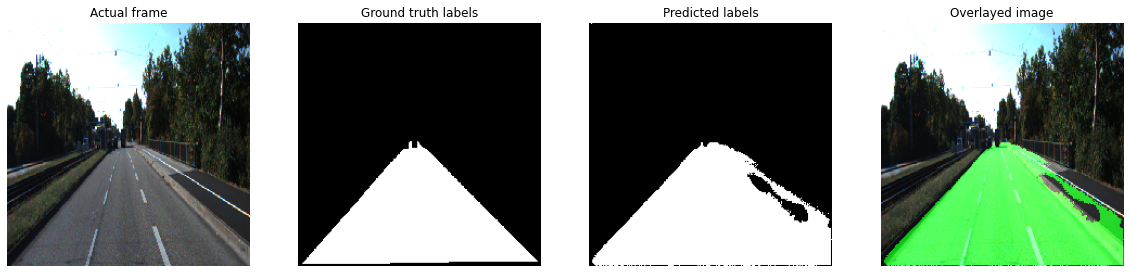

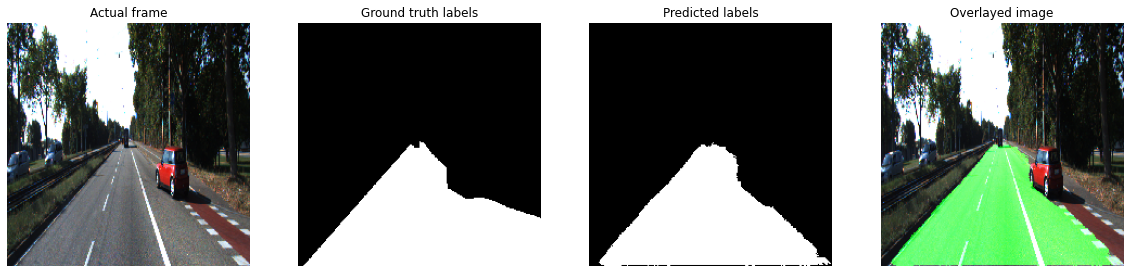

In [ ]:
inference(trained_model, valid_ds)

## 12 Conclusion



In this notebook, we implemented the UNet architecture, and we trained it on the KITTI Road dataset to perform binary segmentation using a cross-entropy loss function. The training accuracy achieved was very close to the FCN-32s model. In the next notebook, we will train UNet on the CamVid dataset which has 32 classes.